In [48]:
from country import *
from disease import disease
from scipy import stats

In [71]:
env = GridEnvironemnt(0.005, 1)
population = [env.random_population() for _ in range(10)] 
#evolve(env : Environment, population, iterations)

population,curve,avg_curve,bests = evolve(env, population, 100)
population = sorted(population, key=lambda x : -env.fitness(x))

In [72]:
best = population[0]
print(env.fitness(best))

2794


In [42]:
from matplotlib import pyplot

def get_infections(grid):
    n = len(grid) 
    m = len(grid[0])
    names = []
    infection_curves = []
    for i in range(n):
        for j in range(m):
            names.append((i,j))
            c = grid[i][j]
            infections = [I for S,I,R,D in c.history]
            inf_curve = [(t, s[1]) for t,s in zip(c.times, c.history)]
            infection_curves.append(inf_curve) 
    total_infections = add_curves(infection_curves)
    return total_infections

def plot_grid_curves(grid, max_population): 
    n = len(grid) 
    m = len(grid[0])
    names = []
    deaths = []
    infection_curves = []
    for i in range(n):
        for j in range(m):
            names.append((i,j))
            c = grid[i][j]
            infections = [I for S,I,R,D in c.history]
            inf_curve = [(t, s[1]) for t,s in zip(c.times, c.history)]
            infection_curves.append(inf_curve)
            deaths.append([(t, s[3]) for t,s in zip(c.times, c.history)])
            plt.plot(c.times, infections) 
    cumulative_deaths = add_curves(deaths)
    total_infections = add_curves(infection_curves)
    plt.plot(cumulative_deaths[0], cumulative_deaths[1])
    plt.plot(total_infections[0], total_infections[1])
    #plt.legend(names+["Cumulative Deaths", "Total Infections"]) 
    plt.xlim(0, total_infections[0][-1])
    plt.ylim(0, max_population)
    plt.show()

def get_peak(curve): 
    max = -math.inf 
    time = 0
    for t,v in curve: 
        if v > max:
            max = v 
            time = t
    return (time, max)

def get_peak_grid(grid): 
    n = len(grid)
    m = len(grid[0])
    peaks = []
    for i in range(n):
        for j in range(m):
            c = grid[i][j] 
            infections = [(t, s[1]) for t,s in zip(c.times, c.history)]
            peaks.append((i, j, get_peak(infections)))
    return peaks

In [22]:
countries,grid = create_grid(best, 0.0005, (3,3), True) 
grid[0][0].current[1] = 5
w = World(countries)
gillespie(w, 0,  t_max=365, max_iter=3*10**5)

In [23]:
peaks = get_peak_grid(grid)

Text(0, 0.5, 'Time of Peak (Days)')

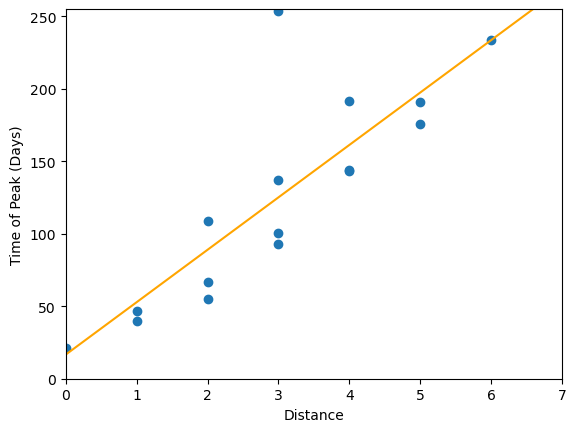

In [38]:
curve = [(i+j, peak[0]) for i,j,peak in peaks]
x = [x for x,y in curve]
y = [y for x,y in curve]
slope, intercept, r, p, std_err = stats.linregress(x, y)
plt.scatter(x,y)
plt.plot([0, max(x)+5], [intercept, slope*(max(x)+5)+intercept],
        color="orange")
plt.ylim(0, max(y)+1)
plt.xlim(0, max(x)+1)
plt.xlabel("Distance")
plt.ylabel("Time of Peak (Days)")

In [40]:
print(slope, intercept, r**2)

36.12312757105832 16.706870392036535 0.6968982589899139


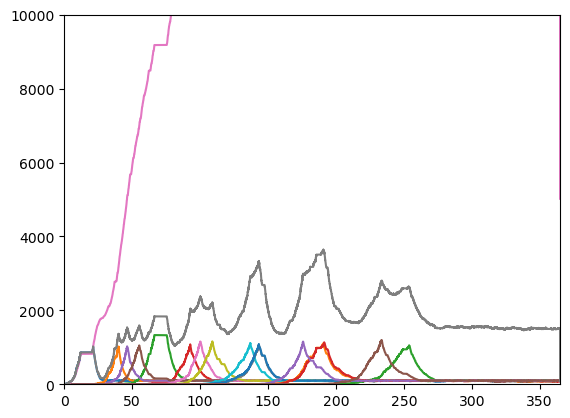

In [30]:
plot_grid_curves(grid,10000)

In [73]:
countries,grid = create_grid(best, 0.005, (2,2), True) 
grid[0][0].current[1] = 5
w = World(countries)
gillespie(w, 0,  t_max=365, max_iter=3*10**5)

In [74]:
infections = get_infections(grid)
print(infections[0][-1])

364.41081821162027


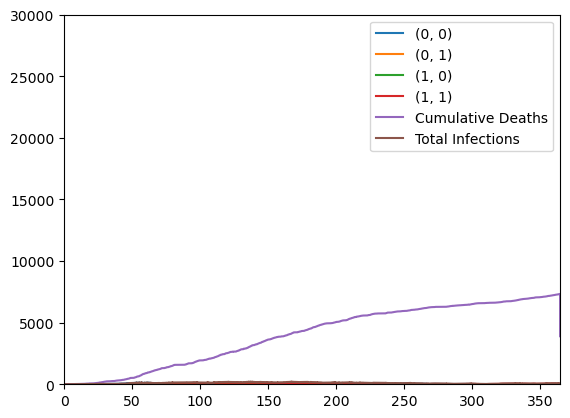

In [75]:
plot_grid_curves(grid, 30000)

In [77]:
best.get_params()

(2.275963002173372e-05,
 0.026508730826335432,
 0.16360796698765065,
 0.00013527916148286812)

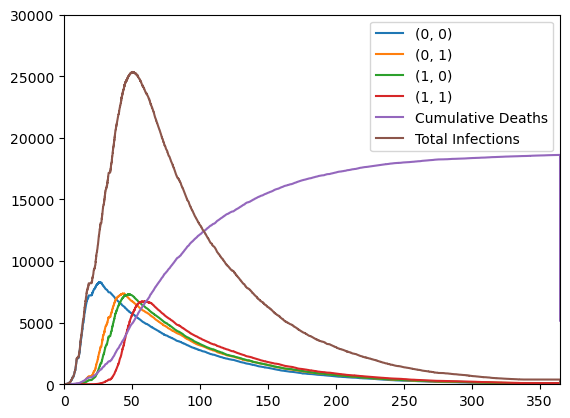

In [78]:
d = disease(2.4106703845780882e-05,
 0.007639597163402223,
 0.007548165319393762,
 0.00028485291605045645)
countries,grid = create_grid(d, 0.005, (2,2), True) 
grid[0][0].current[1] = 5
w = World(countries)
gillespie(w, 0,  t_max=365, max_iter=3*10**5)
plot_grid_curves(grid, 30000)